In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import Utils.dataframe as dataframe_helper
import Utils.learning as learning
import mlflow

In [3]:
pd.set_option('display.max_columns', None)
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment("Behavior & Context (Eng) Model")

<Experiment: artifact_location='../mlruns/563002692616144766', creation_time=1672729337812, experiment_id='563002692616144766', last_update_time=1672729337812, lifecycle_stage='active', name='Behavior & Context (Eng) Model', tags={}>

## Make train dataset

In [4]:
df = dataframe_helper.load_data()
df = dataframe_helper.data_cleaning(df)
df = dataframe_helper.feature_engineering(df)
df.to_csv('../Data/df.csv', index=False)
# df = pd.read_csv('../Data/df.csv')

In [5]:
df.columns

Index(['reviewID', 'reviewerID', 'restaurantID', 'date', 'rating',
       'reviewUsefulCount', 'reviewContent', 'flagged', 'name', 'location',
       'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount',
       'fanCount', 'restaurantRating', 'scaledReviewPerDay', 'reviewsLength',
       'reviewsDeviation', 'maximumContentSimilarity'],
      dtype='object')

In [6]:
df.loc[df['reviewerID'].duplicated(keep=False), ['reviewerID', 'firstCount']]

,reviewerID,firstCount
0,bNYesZ944s6IJVowOnB0iA,5
4,kW2dk1CWihmh3g7k9N2G8A,61
7,BSh3h1J4mdSmEsb8FFdf0Q,2
8,F3mbveXX30Ou0gpDY6IrCQ,11
11,-3Mzc2O6jmYLWQJcIJdvAA,0
...,...,...
26953,tivh8lr6pzBDNfrJLYWh_g,33
26954,jKs4FQgkV0wSX8BG2_dgTg,2
26955,vX6aOMQ3HWCbwZVfCkCauw,7
26956,vX6aOMQ3HWCbwZVfCkCauw,7


In [7]:
df.loc[df['reviewerID'] == 'kW2dk1CWihmh3g7k9N2G8A']

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,scaledReviewPerDay,reviewsLength,reviewsDeviation,maximumContentSimilarity
4,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,9/9/2012,5,1,i idea write review dining alinea brings whole...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.5,0.083333,97,0.125,0.760866
1376,7ihXx,kW2dk1CWihmh3g7k9N2G8A,WBU0yq9J8qiYQfI_fh2P1Q,10/11/2010,3,3,i know write fair review place famous chicken ...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,85,0.250,0.760866
1407,AjjlM34TJOxMp,kW2dk1CWihmh3g7k9N2G8A,IvdOI86_CSCRFpid2atnyA,2/25/2011,5,1,sometimes expect lot place long period time ex...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,107,0.250,0.760866
1958,R271ON9ZzIYGICqHUPddyg,kW2dk1CWihmh3g7k9N2G8A,LYppbvgJlBG0SqjSKFiFGg,4/16/2011,4,0,it took 3 visits cool place really besides gno...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.5,0.166667,35,0.125,0.760866
1959,J-VxrRa0m4FVOUntlJcgqA,kW2dk1CWihmh3g7k9N2G8A,o54U2VkQama8FI30qDkWvw,4/16/2011,5,1,i still like place huge fan bean burger really...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.166667,17,0.250,0.760866
2256,foXoqohEVG3VSvJVic8npA,kW2dk1CWihmh3g7k9N2G8A,JMa9cTNQA5mm4GbR2W8Oiw,3/16/2011,2,3,very honestly disappointed here i wanting try ...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,80,0.500,0.760866
2411,l3qhJzIGHo,kW2dk1CWihmh3g7k9N2G8A,Z2nOMPedr7XYhgYhILJjEA,7/26/2011,5,0,how could i never before this perfect pizza th...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,32,0.250,0.760866
2915,guxSCpzqIsthXHXwkcW0Iw,kW2dk1CWihmh3g7k9N2G8A,oLM9piDKbj2PDgy-m3XEcQ,12/30/2010,5,0,back week lunch i little surprised different a...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,36,0.250,0.760866
3270,HJc5H,kW2dk1CWihmh3g7k9N2G8A,sfWMOqUEp8S2adDeJp7Kzg,4/4/2012,4,0,trip 2 carnivale service good ambiance good fo...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,18,0.000,0.760866
3737,xPqlUGkifq-4d21KN7z2Xg,kW2dk1CWihmh3g7k9N2G8A,oEFJ29zAQaCNnQzebHQvpg,12/18/2010,5,1,a months ago one best friends told nondescript...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.0,0.083333,192,0.250,0.760866


In [8]:
under_sampled_df = dataframe_helper.under_sampling(df=df, target='flagged', big_sample='Y', small_sample='N')
under_sampled_df.to_csv('../Data/under_sampled_df.csv', index=False)
under_sampled_df.reset_index(inplace=True, drop=True)
# under_sampled_df = pd.read_csv('../Data/under_sampled_df.csv')

Under-Sampling Data
Under-Sampling Complete


In [9]:
over_sampled_df = dataframe_helper.over_sampling(df=df, target='flagged', big_sample='Y', small_sample='N')
over_sampled_df.to_csv('../Data/over_sampled_df.csv', index=False)
over_sampled_df.reset_index(inplace=True, drop=True)
# over_sampled_df = pd.read_csv('../Data/over_sampled_df.csv')

Over-Sampling Data
Over-Sampling Complete


# Dataframe EDA

In [10]:
df.head(5)

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,scaledReviewPerDay,reviewsLength,reviewsDeviation,maximumContentSimilarity
0,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,9/22/2012,5,0,unlike next we d eaten previous night dish com...,N,Scott E.,"Glengary, WV",01/10/2009,11,48,5,41,5,5,2,0,1,4.5,0.083333,497,0.125,0.123653
1,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,9/22/2012,5,0,probably one best meals i ve ever it s perform...,N,Jerry K.,"Palos Verdes Peninsula, CA",01/06/2011,0,4,0,0,0,0,0,0,0,4.5,0.083333,41,0.125,0.000000
2,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,9/19/2012,3,2,service impeccable experience presentation coo...,N,Patricia M.,"Chicago, IL",01/09/2008,2,11,0,6,0,1,0,0,0,4.5,0.083333,27,0.375,0.000000
3,iSN,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,9/6/2012,3,8,the problem places like this given exhorbitant...,N,Terry N.,"San Jose, CA",01/10/2007,84,60,1,35,8,6,6,11,0,4.5,0.083333,244,0.375,0.000000
4,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,9/9/2012,5,1,i idea write review dining alinea brings whole...,N,Shradha Vegetarianista A.,"Chicago, IL",01/07/2007,333,1209,61,1650,679,417,283,22,70,4.5,0.083333,97,0.125,0.760866


In [11]:
df.columns

Index(['reviewID', 'reviewerID', 'restaurantID', 'date', 'rating',
       'reviewUsefulCount', 'reviewContent', 'flagged', 'name', 'location',
       'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount',
       'fanCount', 'restaurantRating', 'scaledReviewPerDay', 'reviewsLength',
       'reviewsDeviation', 'maximumContentSimilarity'],
      dtype='object')

In [12]:
train_df = df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged', 'reviewContent', 'restaurantRating'], axis=1)
train_df.to_csv('../Data/train_df.csv', index=False)

In [13]:
train_df.columns

Index(['rating', 'reviewUsefulCount', 'friendCount', 'reviewCount',
       'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount', 'scaledReviewPerDay',
       'reviewsLength', 'reviewsDeviation', 'maximumContentSimilarity'],
      dtype='object')

### Train DF Columns
- rating = comment rating **<span style="color:CornflowerBlue">(raw review file)</span>**
- reviewUsefulCount = number of user's review useful count raw **<span style="color:CornflowerBlue">(count form raw review file)</span>** 
- friendCount = number of user's friend raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- reviewCount = number of user's review count raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- firstCount = number of user's first comment raw **<span style="color:CornflowerBlue">(count form raw review file)</span>** 
- usefulCount = number of comment's useful count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- coolCount = number of comment's cool count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- funnyCount = number of comment's funny count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- complimentCount = review's compliment count raw **<span style="color:CornflowerBlue">(join form tip file)</span>** 
- tipCount = user's tip count raw **<span style="color:CornflowerBlue">(join form tip file)</span>** 
- fanCount = number of user's fan raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- scaledReviewPerDay = scaled review per day raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 
- reviewsLength = review length raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 
- reviewsDeviation = store rating - user rating raw **<span style="color:CornflowerBlue">(calculate form businees and reviews file)</span>**
- maximumContentSimilarity = maximun content similarity raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# %matplotlib inline
# from autoviz.AutoViz_Class import AutoViz_Class
# autoviz = AutoViz_Class().AutoViz('../Data/train_df.csv')

## Model

In [16]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                            n_estimators=500)
nb = GaussianNB()

In [17]:
# semi_supervised_learning(df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
# semi_supervised_learning(df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

In [18]:
# semi_supervised_learning(under_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
# semi_supervised_learning(under_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

2023/01/03 14:03:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Random Forest Model


 20%|██        | 1/5 [01:11<04:46, 71.55s/it]

----------------------------------------


 40%|████      | 2/5 [01:45<02:28, 49.63s/it]

----------------------------------------


 60%|██████    | 3/5 [02:18<01:24, 42.04s/it]

----------------------------------------


 80%|████████  | 4/5 [02:51<00:38, 38.23s/it]

----------------------------------------


100%|██████████| 5/5 [03:23<00:00, 40.77s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.9161526599845798
Precision Score : 0.8774373259052924
Recall Score : 0.968113714944295
F1 Score : 0.9205479452054794
Confusion Matrix : 
[[4466  704]
 [ 166 5040]]


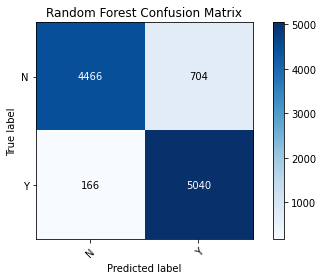

2023/01/03 14:06:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Training Naive Bayes Model


 20%|██        | 1/5 [00:44<02:57, 44.38s/it]

----------------------------------------


 40%|████      | 2/5 [00:49<01:04, 21.47s/it]

----------------------------------------


 60%|██████    | 3/5 [00:55<00:28, 14.17s/it]

----------------------------------------


 80%|████████  | 4/5 [01:00<00:10, 10.70s/it]

----------------------------------------


100%|██████████| 5/5 [01:05<00:00, 13.19s/it]

----------------------------------------
Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.7952004626060138
Precision Score : 0.7157260887830836
Recall Score : 0.9817518248175182
F1 Score : 0.8278934154045516
Confusion Matrix : 
[[3140 2030]
 [  95 5111]]


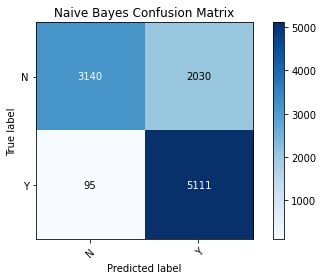

In [19]:
model, results, features = learning.semi_supervised_learning(over_sampled_df, model=rf, threshold=0.7, iterations=5, algorithm='Random Forest',
                drop_columns = ['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate',
                'flagged', 'restaurantRating', 'usefulCount', 'coolCount', 'funnyCount',
                'complimentCount', 'tipCount', 'fanCount'] , target_column ='flagged')
                
model, results, features =  learning.semi_supervised_learning(over_sampled_df, model=nb, threshold=0.7, iterations=5, algorithm='Naive Bayes',          
                drop_columns = ['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate',
                'flagged', 'restaurantRating', 'usefulCount', 'coolCount', 'funnyCount',
                'complimentCount', 'tipCount', 'fanCount'] , target_column ='flagged')

In [20]:
results.to_csv('../Data/results.csv', index=False)